## Use the right version of Tensorflow


In [0]:
%tensorflow_version 2.x

## Call the important statements

The following code imports the necessary code to run the code in the rest of this Colaboratory.

In [2]:
import tensorflow

In [3]:
tensorflow.__version__

'1.15.2'

In [39]:
#@title Call the import statements

import numpy as np
import pandas as pd 
import nltk
import re

#nltk.download('stopwords')
#nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from os import path

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt


from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import  Dense, Activation, Dropout,Bidirectional, GlobalMaxPool1D,BatchNormalization, Embedding,LSTM, Flatten


In [5]:
#@title Load Stopwords, Stemmer, and Lemmatizer

sw = stopwords.words('english')
stemmer = LancasterStemmer()
lemmatizer = WordNetLemmatizer() 

## define the replace_puncts, strip_chars, and puncts

this list and arrays are going to be used in defining the functions

In [6]:
replace_puncts = {'`': "'", '′': "'", '“':'"', '”': '"', '‘': "'"}

strip_chars = [',', '.', '"', ':', ')', '(', '-', '|', ';', "'", '[', ']', '>', '=', '+', '\\', '•',  '~', '@', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

puncts = ['!', '?', '$', '&', '/', '%', '#', '*','£']


## Define functions that clean, lemmatize, process text, and remove stem words from text

The following code defines three functions:

  * `clean_text`, which convert word to lower case and replace some characters
  * `stem`, steam each word in the given text
  * `lemm`, which will lemmatize word
  * `stopwords1`, which remove the stopwords

In [7]:
#@title Define functions that stem, lemmatize, process text, and remove stem words

def clean_text(x):
    x = str(x)
    x = x.lower()
    x = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "url", x)
    for k, v in replace_puncts.items():
        x = x.replace(k, f' {v} ')
        
    for punct in strip_chars:
        x = x.replace(punct, ' ') 
    
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
        
    x = x.replace(" '", " ")
    x = x.replace("' ", " ")
   
    return x

def stopwords1(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)


def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

def lemm(text):    
    text = [lemmatizer.lemmatize(word) for word in text.split()]
    return " ".join(text) 


## define text_processing function

this `text_processing(text)` function incorporate all the function above into one function that will be used to process `text` later

In [8]:
def text_processing(X):
    X=X.apply(stopwords1)
    X=X.apply(clean_text)
    X=X.apply(stemming)
    X=X.apply(lemm)
    return X

## Loading Dataset

in this project, we use data from Kaggle :  [Fake and Real News Dasaset](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset) 


In [9]:
#fake_dataset_url = 'https://raw.githubusercontent.com/Bangkit-2-Jakarta-Team/Fake-News-Detection/master/Datasets/Fake.csv'
#true_dataset_url='https://raw.githubusercontent.com/Bangkit-2-Jakarta-Team/Fake-News-Detection/master/Datasets/True.csv'
fake_dataset_url = "Datasets/Fake.csv"
true_dataset_url = "Datasets/True.csv"
df_fake = pd.read_csv(fake_dataset_url)
df_true = pd.read_csv(true_dataset_url)
df_fake['is_true'] = 0
df_true['is_true'] = 1

#fake_title = df_fake['title']
true_title = df_true['title']

In [10]:
#Merge two dataframe into one
df_data = pd.concat([df_fake,df_true])

In [11]:
#Showing sample
df_data.sample(5)

,title,text,subject,date,is_true
12136,Venezuela talks to resume in January after gov...,CARACAS (Reuters) - Venezuela s government and...,worldnews,"December 16, 2017",1
2181,Texas governor signs bill to limit insurance c...,"AUSTIN, Texas (Reuters) - The Republican gover...",politicsNews,"August 15, 2017",1
11136,N. KOREA WARNS It Will Strike U.S. Bases In S....,"During Obama s 8 years in office, he took a pa...",politics,"Apr 14, 2017",0
2683,Republican senator hopes to kill class-action ...,WASHINGTON (Reuters) - The U.S. Congress could...,politicsNews,"July 19, 2017",1
3318,Court Just Gave Cops Permission To Murder Dogs,The 6th District Court in Ohio ruled on Monday...,News,"December 21, 2016",0


In [12]:
#Randomizing data sequence to scatter data
df_data = shuffle(df_data).reset_index(drop=True)

In [47]:
x = df_data['title']
y = df_data['is_true']

In [48]:
x_clean = text_processing(x)

In [64]:
x_train, x_test, y_train, y_test = train_test_split(x_clean, y, test_size=0.3, random_state = 42)

In [65]:
y_test_temp = y_test

max_words = 2000
tokenize = text.Tokenizer(num_words=max_words)
tokenize.fit_on_texts(x_train) # only fit on train
x_train_tok = tokenize.texts_to_sequences(x_train)
x_test_tok = tokenize.texts_to_sequences(x_test)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

## Generating Wordcloud that show most common word in News Title

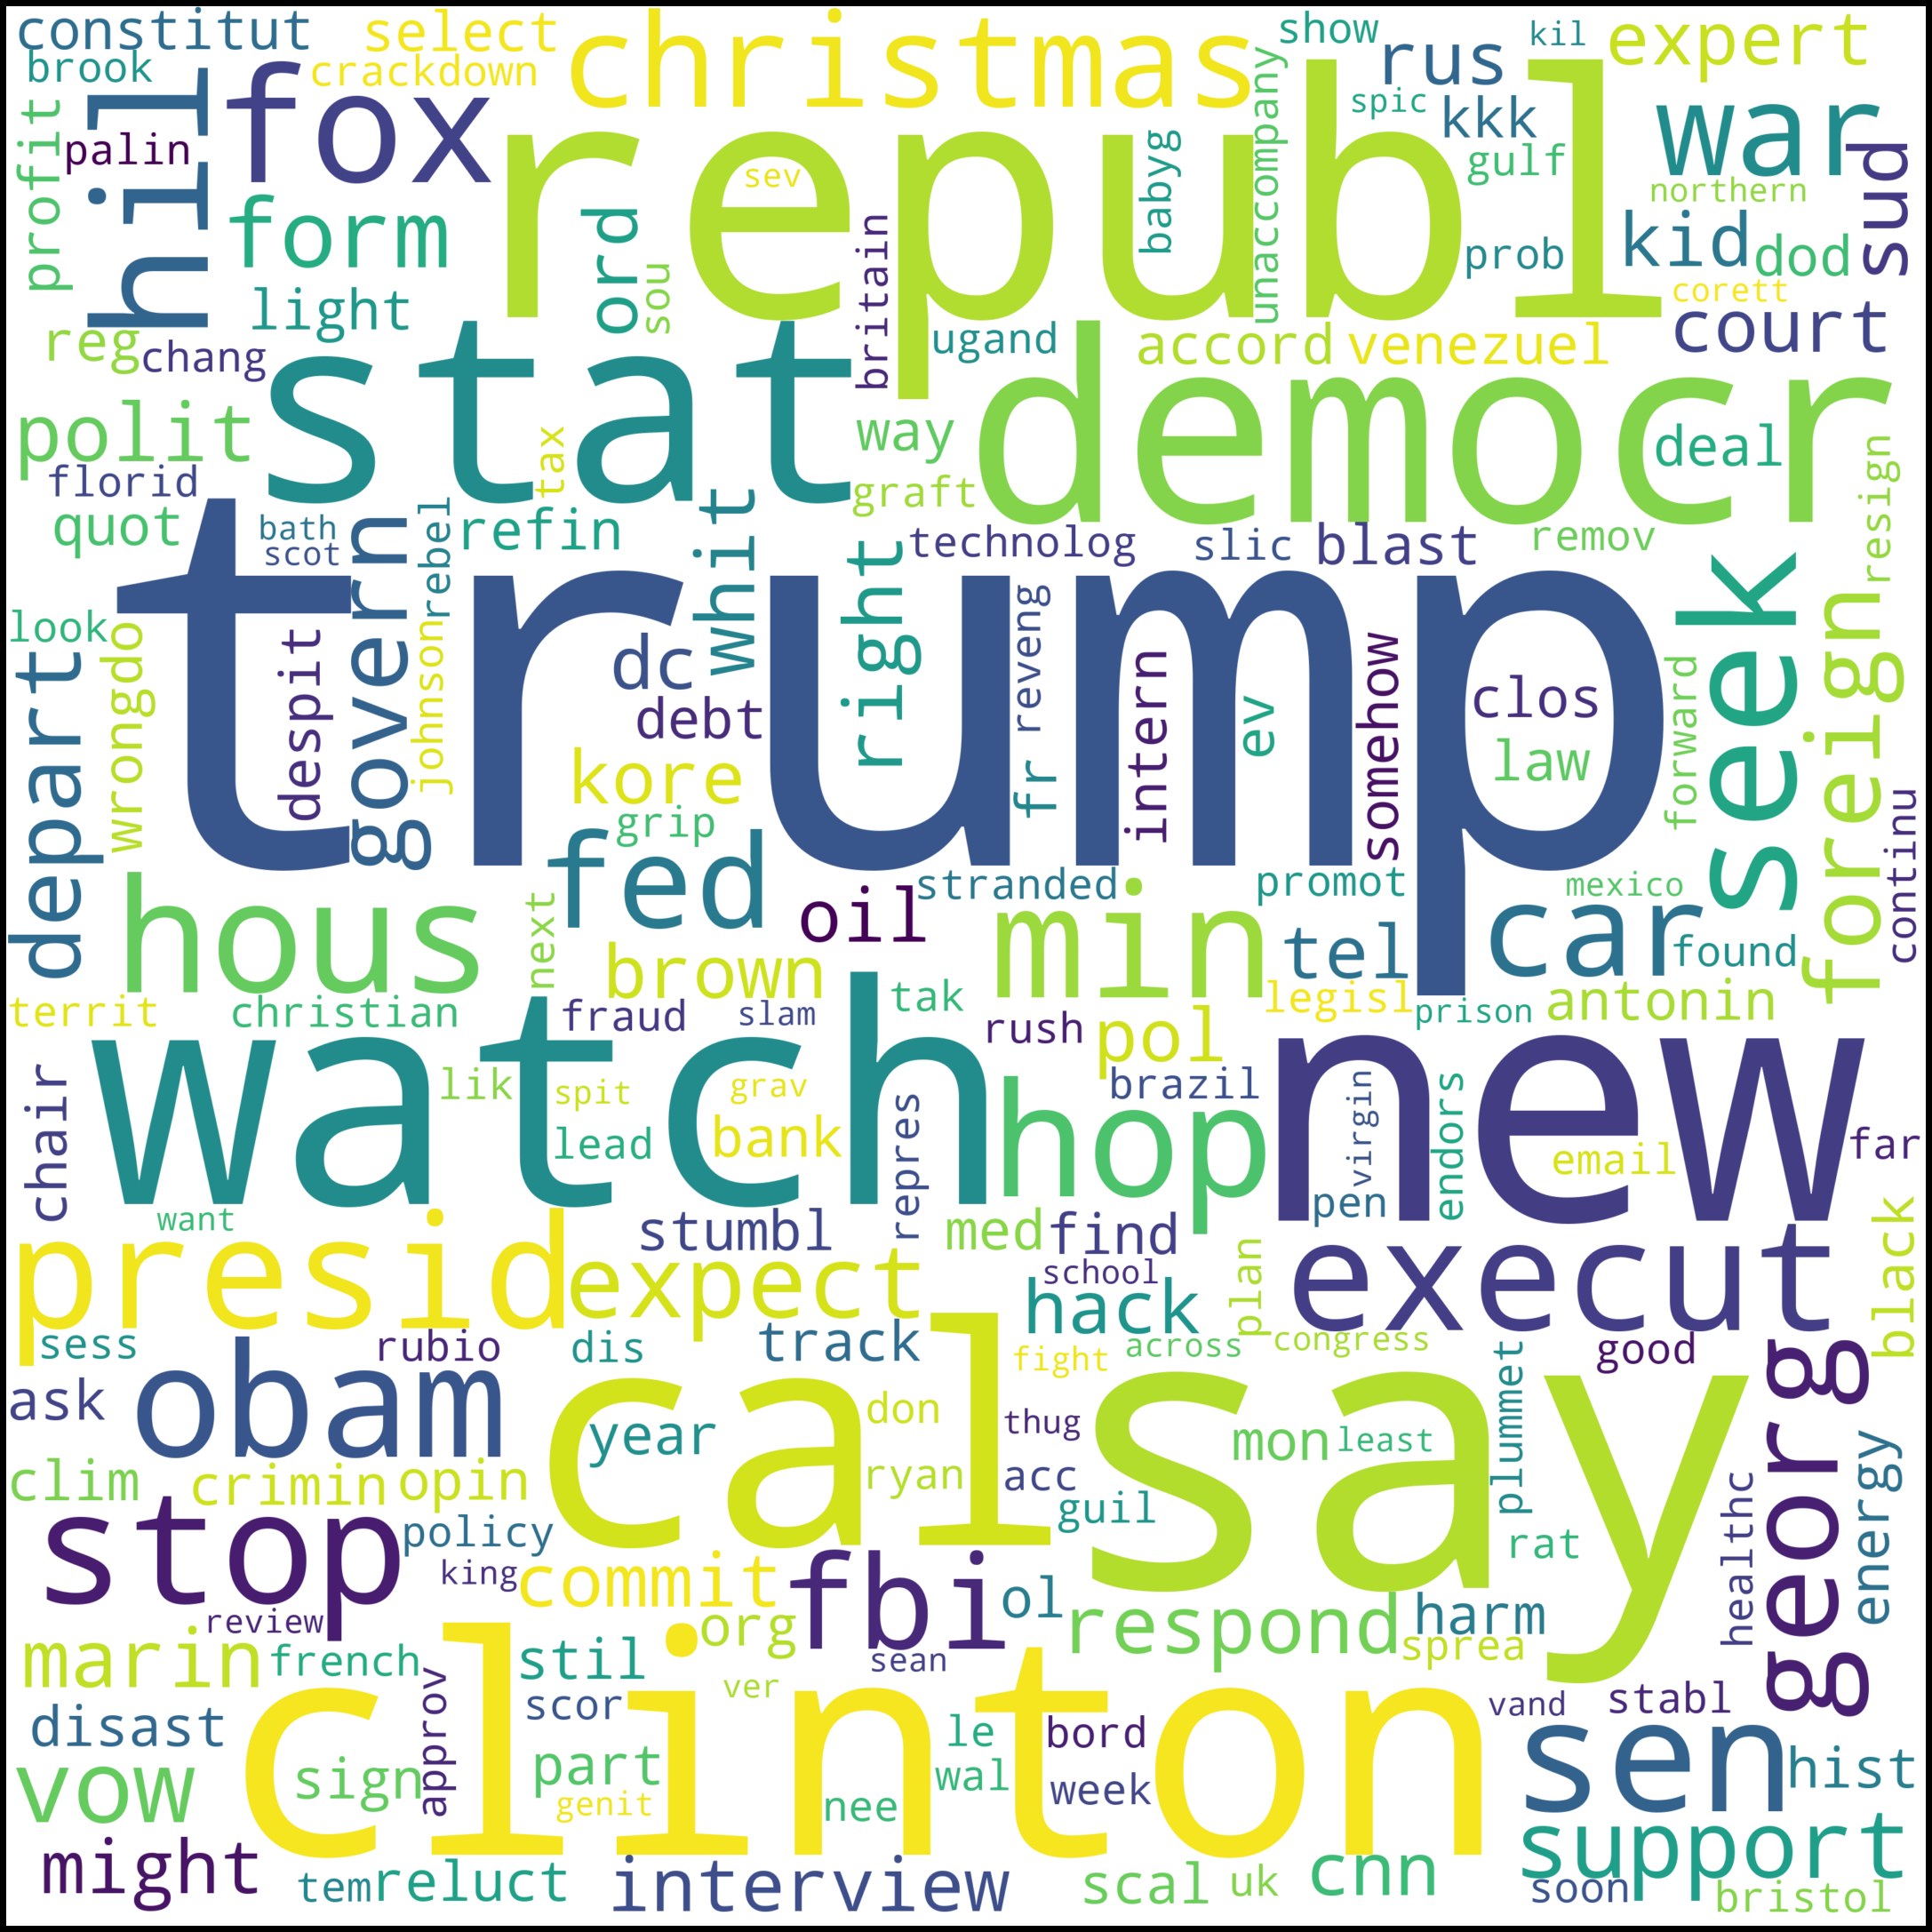

In [37]:
#Counting Unique word to generate WordCloud
text1 = clean_x
wordcloud= WordCloud(
    width =3000,
    height = 3000,
    background_color='white',
    stopwords=STOPWORDS).generate(str(text1))
fig = plt.figure(
    figsize = (40,30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


In [66]:
max_sequences= 100
x_train=pad_sequences(x_train_tok,maxlen=max_sequences)
x_test=pad_sequences(x_test_tok,maxlen=max_sequences)

In [67]:
#LSTM DTS
embed_size = 128

model = Sequential()
model.add(Embedding(max_words,embed_size,input_length=max_sequences))
model.add(Bidirectional((LSTM(64,return_sequences = True,recurrent_dropout=0.5))))
model.add(Dropout(0.6))
model.add(BatchNormalization())
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(len(y.unique()), activation="softmax"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [68]:
batch_size = 64
epochs = 10

#callbacks = [EarlyStopping(monitor='val_loss', patience=4, verbose=1),]
    
history3 =model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
          validation_split=0.2)

Train on 25142 samples, validate on 6286 samples
Epoch 1/10
25142/25142 [==============================] - 104s 4ms/sample - loss: 0.2493 - acc: 0.8893 - val_loss: 0.4065 - val_acc: 0.9217
Epoch 2/10
25142/25142 [==============================] - 103s 4ms/sample - loss: 0.1525 - acc: 0.9405 - val_loss: 0.2093 - val_acc: 0.9106
Epoch 3/10
25142/25142 [==============================] - 101s 4ms/sample - loss: 0.1243 - acc: 0.9498 - val_loss: 0.1762 - val_acc: 0.9281
Epoch 4/10
25142/25142 [==============================] - 100s 4ms/sample - loss: 0.1085 - acc: 0.9556 - val_loss: 0.1531 - val_acc: 0.9407
Epoch 5/10
25142/25142 [==============================] - 106s 4ms/sample - loss: 0.0921 - acc: 0.9611 - val_loss: 0.1731 - val_acc: 0.9257
Epoch 6/10
25142/25142 [==============================] - 107s 4ms/sample - loss: 0.0821 - acc: 0.9645 - val_loss: 0.1733 - val_acc: 0.9289
Epoch 7/10
25142/25142 [==============================] - 105s 4ms/sample - loss: 0.0729 - acc: 0.9679 - val_lo

In [70]:
accr1 = model.evaluate(x_test,y_test)

13470/13470 [==============================] - 10s 776us/sample - loss: 0.1822 - acc: 0.9350


In [71]:
print('AKURASI DARI LSTM \nTest set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr1[0],accr1[1]))

AKURASI DARI LSTM 
Test set
  Loss: 0.182
  Accuracy: 0.935
